In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

from functions.plot_metrics import plot_metrics
from functions.plot_metrics_one import plot_metrics_one
from functions import calc_metrics

In [145]:
data_water=parse.parse('cloudrm2_water.dat')
data_clear=parse.parse('cloudrm2_clear.dat')
data_ice=parse.parse('cloudrm2_ice.dat')
data_mixed=parse.parse('cloudrm2_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water,data_clear,data_ice,data_mixed,
#                    data_black_water,data_black_clear,data_black_ice,data_black_mixed])
data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])


data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']
#clear_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
#              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
#              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

#y_labels= ['OCloud_B02','OCloud_B03','OCloud_B04','OCloud_B05','OCloud_B06',
#           'OCloud_B07','OCloud_B08','OCloud_B09','OCloud_B10','OCloud_B11','OCloud_B12','OCloud_B13']

#df[y_labels]=df[X_labels].to_numpy()-df[clear_labels].to_numpy()

In [146]:
main_filepath='pytorch_models/cont_test'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

X_test=pd.read_csv(main_filepath+'/xtest.csv',index_col=0)
y_test=pd.read_csv(main_filepath+'/ytest.csv',index_col=0)
y_true=y_test.to_numpy()
#y_true=df.iloc[y_test.index][clear_labels]

In [147]:
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X_test.to_numpy(),axis=0)*0.03

In [148]:
for i,model in enumerate(models):
    if i==0:
        pred_y=model.predict(X_test.to_numpy())
    else:   
        pred_y=pred_y+model.predict(X_test.to_numpy())
pred_y=pred_y/len(models)

#X_tmp=np.zeros((np.shape(X_test.to_numpy())[0],np.shape(X_test.to_numpy())[1],9))
#for i in range(np.shape(X_tmp)[2]):
#    X_tmp[:,:,i]=X_test.to_numpy()

#pred_y=X_tmp-pred_y #For cloud estimation

In [149]:
tmp=models[0]
loss=tmp.train_loss.data.cpu().numpy()
np.argmin(loss[loss>0])

513

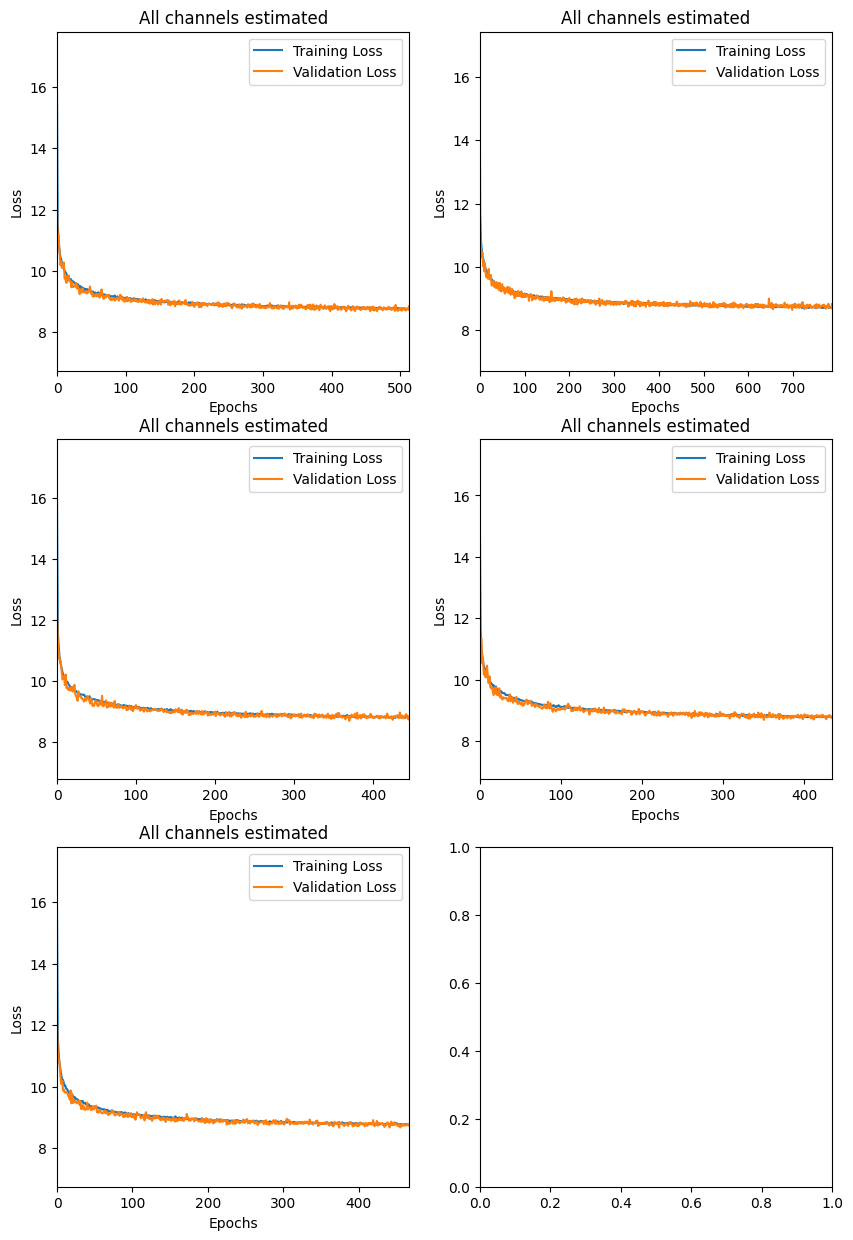

In [150]:
nmodels=len(models)
ncols=2
nrows=int(np.ceil(nmodels/ncols))
plt.rcParams["figure.figsize"] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):
    if i<nmodels:
        train_loss=models[i].train_loss.data.cpu().numpy()
        train_loss_l0=train_loss[train_loss>0]
        val_loss=models[i].val_loss.data.cpu().numpy()
        val_loss_l0=val_loss[val_loss>0]
        ax.plot(train_loss)
        ax.plot(val_loss)
        ax.set_title("All channels estimated")
        ax.legend(['Training Loss','Validation Loss'])
        ax.set_xlim(0,np.max([np.argmin(train_loss_l0),np.argmin(val_loss_l0)]))
        ax.set_ylim(np.min(train_loss_l0)-2,np.max(train_loss_l0)+2)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")

In [151]:
np.shape(pred_y)

(20000, 12, 9)

In [152]:
np.shape(y_test)

(20000, 12)

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/edgelab/filip/SEEX30_Cloud_Fog/SEEX30_Cloud_Fog/Cloud_rm/functions/plot_metrics_one.py:194: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[f_i].errorbar(x=np.linspace(0,len(y_pred_sort_samp[i][:,index_median]),len(y_pred_sort_samp[i][:,index_median]))


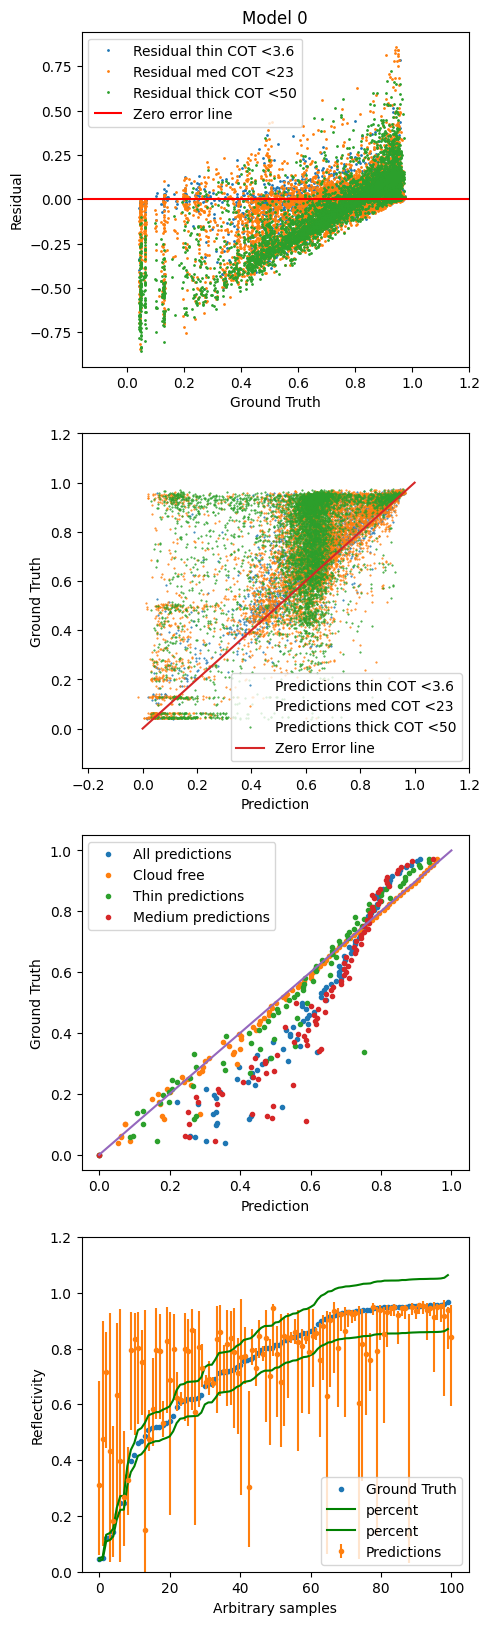

In [153]:
plt.rcParams["figure.figsize"] = [5, 5*4]
figs,axs,mses,r2s,psnrs,quantrates,quantcrosses = plot_metrics_one([models],
                                                                [X_test],
                                                                [y_test],
                                                                [pred_y],
                                                                df,
                                                                samples=100,
                                                                is_ensemble=True,
                                                                index_median=4)

In [154]:
#Indices for different COT
cot_thin=3.6
cot_med=23
cot_thick=50

#Get indexes for optical thin, med and thick
test_indices=X_test.index
df_tmp=df.iloc[test_indices]

#Reset index for future indexing
df_tmp=df_tmp.reset_index()
df_tmp=df_tmp.drop(columns=["index"])

indices_zero=df_tmp[df_tmp['COT']==0].index
indices_thin=df_tmp[(df_tmp['COT']<=cot_thin)&df_tmp['COT']>0].index
indices_med=df_tmp[(df_tmp['COT']>cot_thin)&(df_tmp['COT']<=cot_med)].index
indices_thick=df_tmp[df_tmp['COT']>cot_med].index

/tmp/ipykernel_45633/468801031.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[0,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_45633/468801031.py:52: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[0,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_45633/468801031.py:74: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axs[1,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
/tmp/ipykernel_45633/468801031.py:96: UserWarning: marker is redund

Text(0.5, 1.0, '23 < COT < 50 (thick)')

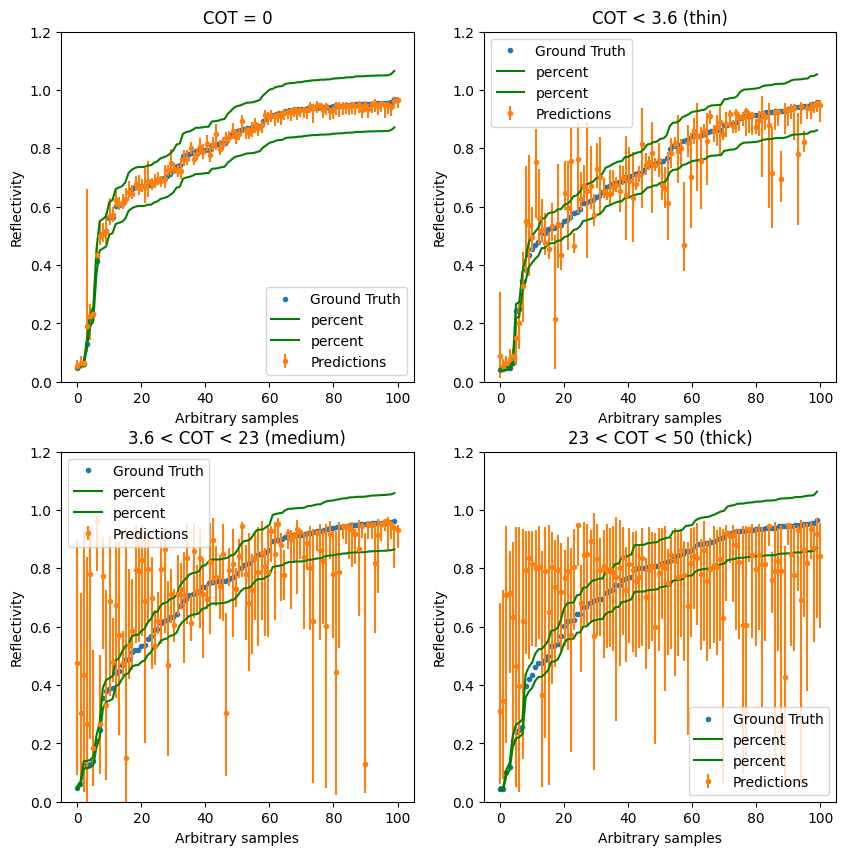

In [155]:

plt.rcParams["figure.figsize"] = [10, 10]
fig, axs=plt.subplots(ncols=2,nrows=2)
samples=100
index_median=4
#sort=np.argsort(y_true)
#y_true_sort=y_true[sort]
#y_pred_sort=pred_y[sort]
y_true_11=y_true[:,10]
pred_y_11=pred_y[:,10,:]

y_true_11_zero=y_true_11[indices_zero]
y_true_11_thin=y_true_11[indices_thin]
y_true_11_med=y_true_11[indices_med]
y_true_11_thick=y_true_11[indices_thick]

pred_y_11_zero=pred_y_11[indices_zero]
pred_y_11_thin=pred_y_11[indices_thin]
pred_y_11_med=pred_y_11[indices_med]
pred_y_11_thick=pred_y_11[indices_thick]


## ZERO COT ##
y_samp=y_true_11_zero[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_zero[:samples][sort]
# Plot the values
axs[0,0].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[0,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[0,0].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='percent')
axs[0,0].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='percent')
axs[0,0].set_xlabel("Arbitrary samples")
axs[0,0].set_ylabel("Reflectivity")
axs[0,0].set_ylim((0,1.2))
axs[0,0].legend()
axs[0,0].set_title("COT = 0")



y_samp=y_true_11_thin[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_thin[:samples][sort]
# Plot the values
axs[0,1].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[0,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[0,1].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='percent')
axs[0,1].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='percent')
axs[0,1].set_xlabel("Arbitrary samples")
axs[0,1].set_ylabel("Reflectivity")
axs[0,1].set_ylim((0,1.2))
axs[0,1].legend()
axs[0,1].set_title("COT < 3.6 (thin)")


y_samp=y_true_11_med[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_med[:samples][sort]
# Plot the values
axs[1,0].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[1,0].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[1,0].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='percent')
axs[1,0].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='percent')
axs[1,0].set_xlabel("Arbitrary samples")
axs[1,0].set_ylabel("Reflectivity")
axs[1,0].set_ylim((0,1.2))
axs[1,0].legend()
axs[1,0].set_title("3.6 < COT < 23 (medium)")


y_samp=y_true_11_thick[:samples]
sort=np.argsort(y_samp)
y_true_sort_samp=y_samp[sort]
y_pred_sort_samp=pred_y_11_thick[:samples][sort]
# Plot the values
axs[1,1].plot(y_true_sort_samp,'.',label='Ground Truth')
axs[1,1].errorbar(x=np.linspace(0,len(y_pred_sort_samp[:,index_median]),len(y_pred_sort_samp[:,index_median])),
            y=y_pred_sort_samp[:,index_median],
            yerr=[np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,0]),
                np.abs(y_pred_sort_samp[:,index_median]-y_pred_sort_samp[:,-1])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
axs[1,1].plot(y_true_sort_samp-y_true_sort_samp*percent,'g',label='percent')
axs[1,1].plot(y_true_sort_samp+y_true_sort_samp*percent,'g',label='percent')
axs[1,1].set_xlabel("Arbitrary samples")
axs[1,1].set_ylabel("Reflectivity")
axs[1,1].set_ylim((0,1.2))
axs[1,1].legend()
axs[1,1].set_title("23 < COT < 50 (thick)")

In [156]:
MSE=[]
R2=[]
PSNR=[]
quantrates=[]
quantcross=[]

MSE.append(mean_squared_error(y_true,pred_y[:,:,4]))
R2.append(r2_score(y_true,pred_y[:,:,4]))
PSNR.append(calc_metrics.PSNR(y_true,pred_y[:,:,4]))
quantrates.append(calc_metrics.quant_rate(y_true,pred_y))
quantcross.append(calc_metrics.quant_cross(pred_y))

In [157]:

print("MSE: "+str(MSE[0]))
print(" ")
print("R2 score: "+str(R2[0]))
print(" ")

print("PSNR: "+str(PSNR[0]))
print(" ")
print("Quantrate: "+str(quantrates[0]))
print(" ")
print("Quantile crossing: "+str(quantcross[0]))

MSE: 0.0077233084702195455
 
R2 score: 0.8243306455727604
 
PSNR: 21.153942544788762
 
Quantrate: [0.08201667 0.154775   0.25039583 0.3566125  0.47238333 0.588875
 0.70996667 0.8187125  0.91997917]
 
Quantile crossing: 0.0


In [158]:
test_indices=X_test.index
df_test=df.loc[test_indices]
df_test=df_test.reset_index()
df_test_clear=df_test[df_test['COT']==0]
df_test_thin=df_test[(df_test['COT']<=3.6) & (df_test['COT']>0)]
df_test_med=df_test[(df_test['COT']<=23) & (df_test['COT']>3.6)]
df_test_thick=df_test[(df_test['COT']<=50) & (df_test['COT']>23)]

In [159]:

MSE_cot_levels=[]
MSE_cot_levels.append(mean_squared_error(y_true,pred_y[:,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_clear.index],pred_y[df_test_clear.index,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_thin.index],pred_y[df_test_thin.index,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_med.index],pred_y[df_test_med.index,:,4]))
MSE_cot_levels.append(mean_squared_error(y_true[df_test_thick.index],pred_y[df_test_thick.index,:,4]))

In [160]:
print("MSE all test data: "+str(MSE_cot_levels[0]))
print("MSE clear test data: "+str(MSE_cot_levels[1]))
print("MSE thin COT <3.6 test data: "+str(MSE_cot_levels[2]))
print("MSE med COT <23 test data: "+str(MSE_cot_levels[3]))
print("MSE thick COT <50 test data: "+str(MSE_cot_levels[4]))

MSE all test data: 0.0077233084702195455
MSE clear test data: 0.00031159339459016917
MSE thin COT <3.6 test data: 0.0023087743320246356
MSE med COT <23 test data: 0.0068394600992060005
MSE thick COT <50 test data: 0.01825147844463484
